-----
# <b> Altegrad 2023/2024 - LAB 7
# <b> Learning on Sets and Graph Generative Models
# <b> Matteo Marengo - matteo.marengo@ens-paris-saclay.fr
# <b> Part 1 - DeepSets
-----

## <b> TASK 1 / 2

In [1]:
"""
Learning on Sets and Graph Generative Models - ALTEGRAD - Nov 2023
Matteo Marengo - matteo.marengo@ens-paris-saclay.fr
utils.py - 1/4
"""

import numpy as np


def create_train_dataset():
    n_train = 100000
    max_train_card = 10

    ############## Task 1
    ##################
    X_train = np.zeros((n_train, max_train_card))
    y_train = np.zeros(n_train)

    for i in range(n_train):
        card = np.random.randint(1, max_train_card + 1)
        X_train[i, -card:] = np.random.randint(1, max_train_card + 1, size=card)
        y_train[i] = np.sum(X_train[i, :])

    print("The 1st training sample is:", X_train[0, :])
    print("The 1st training label is:", y_train[0])
    ##################

    return X_train, y_train


def create_test_dataset():
    ############## Task 2
    ##################
    n_test = 200000
    min_test_card = 5
    max_test_card = 101
    step_test_card = 5
    cards = range(min_test_card, max_test_card, step_test_card)
    n_samples_per_card = n_test // len(cards)

    X_test = list()
    y_test = list()

    for card in cards:
        X = np.random.randint(1, 11, size=(n_samples_per_card, card))
        y = np.sum(X, axis=1)

        X_test.append(X)
        y_test.append(y)

        return X_test, y_test

    # n_test = 200000
    # min_test_card = 5
    # max_test_card = 100

    # X_test = []
    # y_test = []

    # for M in range(min_test_card, max_test_card + 1, 5):
    #     for _ in range(int(n_test / (max_test_card - min_test_card + 1))):
    #         digits = np.random.choice(range(1, 11), size=M, replace=False)
    #         padded_digits = np.pad(digits, (max_test_card - M, 0), mode='constant')
    #         X_test.append(padded_digits)
    #         y_test.append(sum(digits))

    ##################

    return X_test, y_test

## <b> TASK 3 / 4

In [2]:
"""
Learning on Sets and Graph Generative Models - ALTEGRAD - Nov 2023
Matteo Marengo - matteo.marengo@ens-paris-saclay.fr
models.py - 2/4
"""

import torch
import torch.nn as nn

class DeepSets(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim):
        super(DeepSets, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        ############## Task 3
        ##################
        x = self.embedding(x)  # Embedding layer
        x = self.tanh(self.fc1(x))
        x = torch.sum(x, dim=1)
        x = self.fc2(x)

        # embedded = self.embedding(x)
        # embedded = self.tanh(embedded)
        # summed = torch.sum(embedded, dim=1)  # Sum aggregator
        # hidden = self.fc1(summed)  # Fully-connected layer with h2 hidden units
        # hidden = self.tanh(hidden)  # Tanh activation function
        # x = self.fc2(hidden)  # Fully-connected layer with 1 unit
        ##################
        return x.squeeze()


class LSTM(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        ############## Task 4
        ##################
        x = self.embedding(x)  # Embedding layer
        _, (x, _) = self.lstm(x)  # LSTM layer
        x = self.fc(x)  # Fully-connected layer   
        ##################x
        return x.squeeze()


## <b> TASK 5

In [3]:
"""
Learning on Sets and Graph Generative Models - ALTEGRAD - Nov 2023
Matteo Marengo - matteo.marengo@ens-paris-saclay.fr
train.py - 3/4
"""

import time
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn

# from utils import create_train_dataset
# from models import DeepSets, LSTM


# Initializes device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 20
batch_size = 64
embedding_dim = 128
hidden_dim = 64
learning_rate = 0.001

# Generates training data
X_train, y_train = create_train_dataset()
n_train = 100000
n_digits = 11

# Initializes DeepSets model and optimizer
deepsets = DeepSets(n_digits, embedding_dim, hidden_dim).to(device)
optimizer = optim.Adam(deepsets.parameters(), lr=learning_rate)
loss_function = nn.L1Loss()

# Trains the DeepSets model
for epoch in range(epochs):
    t = time.time()
    deepsets.train()
     
    train_loss = 0
    count = 0
    idx = np.random.permutation(n_train)
    for i in range(0, n_train, batch_size):
        ############## Task 5
        ##################
        # define a list
        x_batch = []
        y_batch = []
        for j in range(i, min(i+batch_size,n_train)):
            x_batch.append(X_train[idx[j]])
            y_batch.append(y_train[idx[j]])

        # Convert the numpy arrays to torch tensors
        x_batch = torch.LongTensor(x_batch).to(device)
        y_batch = torch.LongTensor(y_batch).to(device)

        
        ##################
        optimizer.zero_grad()
        output = deepsets(x_batch)
        loss = loss_function(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * output.size(0)
        count += output.size(0)
    
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(train_loss / count),
          'time: {:.4f}s'.format(time.time() - t))

# Stores DeepSets model into disk
torch.save({
    'state_dict': deepsets.state_dict(),
    'optimizer' : optimizer.state_dict(),
}, 'model_deepsets.pth.tar')

print("Finished training for DeepSets model")
print()

# Initializes LSTM model and optimizer
lstm = LSTM(n_digits, embedding_dim, hidden_dim).to(device)
optimizer = optim.Adam(lstm.parameters(), lr=learning_rate)
loss_function = nn.L1Loss()

# Trains the LSTM model
for epoch in range(epochs):
    t = time.time()
    lstm.train()
     
    train_loss = 0
    count = 0
    idx = np.random.permutation(n_train)
    for i in range(0, n_train, batch_size):
    
        ############## Task 5
        
        ##################
        # define a list
        x_batch = []
        y_batch = []
        for j in range(i, min(i+batch_size,n_train)):
            x_batch.append(X_train[idx[j]])
            y_batch.append(y_train[idx[j]])

        # Convert the numpy arrays to torch tensors
        x_batch = torch.LongTensor(x_batch).to(device)
        y_batch = torch.LongTensor(y_batch).to(device)
        ##################
        
        optimizer.zero_grad()
        output = lstm(x_batch)
        loss = loss_function(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * output.size(0)
        count += output.size(0)
    
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(train_loss / count),
          'time: {:.4f}s'.format(time.time() - t))

# Stores LSTM model into disk
torch.save({
    'state_dict': lstm.state_dict(),
    'optimizer' : optimizer.state_dict(),
}, 'model_lstm.pth.tar')

print("Finished training for LSTM model")

c:\Users\matte\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\cuda\__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ..\c10\cuda\CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


The 1st training sample is: [ 0.  4.  9. 10.  3. 10.  4.  5.  8.  4.]
The 1st training label is: 57.0


c:\Users\matte\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\matte\AppData\Local\Temp\ipykernel_18964\2305721928.py:56: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  x_batch = torch.LongTensor(x_batch).to(device)


Epoch: 0001 loss_train: 0.9446 time: 5.0399s
Epoch: 0002 loss_train: 0.0768 time: 4.9810s
Epoch: 0003 loss_train: 0.0607 time: 5.0774s
Epoch: 0004 loss_train: 0.0487 time: 5.0890s
Epoch: 0005 loss_train: 0.0405 time: 5.0480s
Epoch: 0006 loss_train: 0.0390 time: 5.1724s
Epoch: 0007 loss_train: 0.0358 time: 5.1148s
Epoch: 0008 loss_train: 0.0363 time: 5.0119s
Epoch: 0009 loss_train: 0.0337 time: 5.1212s
Epoch: 0010 loss_train: 0.0317 time: 4.9085s
Epoch: 0011 loss_train: 0.0316 time: 5.0682s
Epoch: 0012 loss_train: 0.0291 time: 6.6438s
Epoch: 0013 loss_train: 0.0283 time: 4.6843s
Epoch: 0014 loss_train: 0.0275 time: 4.9504s
Epoch: 0015 loss_train: 0.0291 time: 5.6907s
Epoch: 0016 loss_train: 0.0309 time: 4.9843s
Epoch: 0017 loss_train: 0.0278 time: 6.0012s
Epoch: 0018 loss_train: 0.0280 time: 7.5499s
Epoch: 0019 loss_train: 0.0279 time: 6.8322s
Epoch: 0020 loss_train: 0.0258 time: 7.7683s
Finished training for DeepSets model

Epoch: 0001 loss_train: 6.5235 time: 13.4405s
Epoch: 0002 loss

Loading DeepSets checkpoint!
Loading LSTM checkpoint!


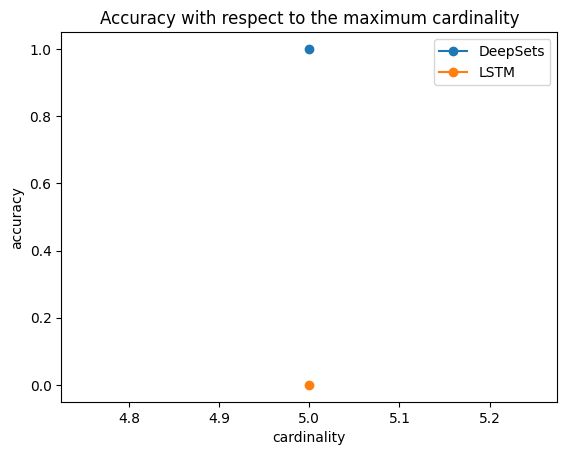

In [5]:
"""
Learning on Sets and Graph Generative Models - ALTEGRAD - Nov 2023
Matteo Marengo - matteo.marengo@ens-paris-saclay.fr
eval.py - 4/4
"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_absolute_error
import torch
import time
# from utils import create_test_dataset
# from models import DeepSets, LSTM

# Initializes device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
batch_size = 64
embedding_dim = 128
hidden_dim = 64

# Generates test data
X_test, y_test = create_test_dataset()
cards = [X_test[i].shape[1] for i in range(len(X_test))]
n_samples_per_card = X_test[0].shape[0]
n_digits = 11

# Retrieves DeepSets model
deepsets = DeepSets(n_digits, embedding_dim, hidden_dim).to(device)
print("Loading DeepSets checkpoint!")
checkpoint = torch.load('model_deepsets.pth.tar')
deepsets.load_state_dict(checkpoint['state_dict'])
deepsets.eval()

# Retrieves LSTM model
lstm = LSTM(n_digits, embedding_dim, hidden_dim).to(device)
print("Loading LSTM checkpoint!")
checkpoint = torch.load('model_lstm.pth.tar')
lstm.load_state_dict(checkpoint['state_dict'])
lstm.eval()

# Dict to store the results
results = {'deepsets': {'acc':[], 'mae':[]}, 'lstm': {'acc':[], 'mae':[]}}

for i in range(len(cards)):
    y_pred_deepsets = list()
    y_pred_lstm = list()
    for j in range(0, n_samples_per_card, batch_size):
        
        ############## Task 6
    
        ##################
        # your code here #
        x_batch = X_test[i][j:min(j+batch_size, n_samples_per_card), :]
        
        x_batch = torch.LongTensor(x_batch).to(device)
        
        outpout_deepset = deepsets(x_batch)
        y_pred_deepsets.append(outpout_deepset)
        
        output_lsstm = lstm(x_batch)
        y_pred_lstm.append(output_lsstm)
        ##################
        
    y_pred_deepsets = torch.cat(y_pred_deepsets)
    y_pred_deepsets = y_pred_deepsets.detach().cpu().numpy()
    
    acc_deepsets = accuracy_score(y_test[i], np.round(y_pred_deepsets))
    mae_deepsets = mean_absolute_error(y_test[i], np.round(y_pred_deepsets))
    results['deepsets']['acc'].append(acc_deepsets)
    results['deepsets']['mae'].append(mae_deepsets)
    
    y_pred_lstm = torch.cat(y_pred_lstm)
    y_pred_lstm = y_pred_lstm.detach().cpu().numpy()
    
    acc_lstm = accuracy_score(y_test[i], np.round(y_pred_lstm))
    mae_lstm = mean_absolute_error(y_test[i], np.round(y_pred_lstm))
    results['lstm']['acc'].append(acc_lstm)
    results['lstm']['mae'].append(mae_lstm)


############## Task 7
    
plt.plot(cards, results['deepsets']['acc'], '-o', label='DeepSets')
plt.plot(cards, results['lstm']['acc'], '-o', label='LSTM')
plt.xlabel('cardinality')
plt.ylabel('accuracy')
plt.legend()
plt.title('Accuracy with respect to the maximum cardinality')
plt.show()

Loading DeepSets checkpoint!
Loading LSTM checkpoint!


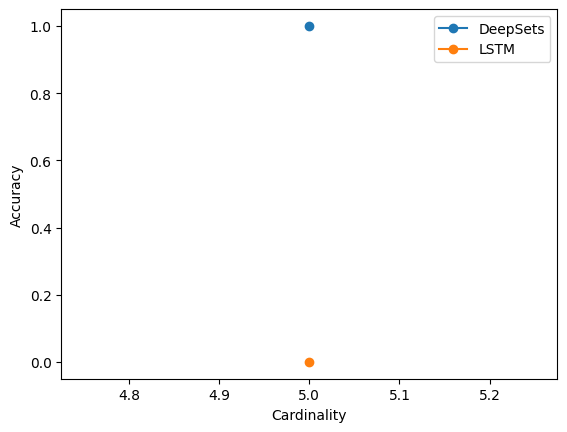

In [4]:
"""
Learning on Sets and Graph Generative Models - ALTEGRAD - Nov 2023
Matteo Marengo - matteo.marengo@ens-paris-saclay.fr
eval.py - 4/4
"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_absolute_error
import torch

# from utils import create_test_dataset
# from models import DeepSets, LSTM

# Initializes device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
batch_size = 64
embedding_dim = 128
hidden_dim = 64

# Generates test data
X_test, y_test = create_test_dataset()
cards = [X_test[i].shape[1] for i in range(len(X_test))]
n_samples_per_card = X_test[0].shape[0]
n_digits = 11

# Retrieves DeepSets model
deepsets = DeepSets(n_digits, embedding_dim, hidden_dim).to(device)
print("Loading DeepSets checkpoint!")
checkpoint = torch.load('model_deepsets.pth.tar')
deepsets.load_state_dict(checkpoint['state_dict'])
deepsets.eval()

# Retrieves LSTM model
lstm = LSTM(n_digits, embedding_dim, hidden_dim).to(device)
print("Loading LSTM checkpoint!")
checkpoint = torch.load('model_lstm.pth.tar')
lstm.load_state_dict(checkpoint['state_dict'])
lstm.eval()

# Dict to store the results
results = {'deepsets': {'acc':[], 'mae':[]}, 'lstm': {'acc':[], 'mae':[]}}

for i in range(len(cards)):
    y_pred_deepsets = list()
    y_pred_lstm = list()
    for j in range(0, n_samples_per_card, batch_size):
        
        ############## Task 6
    
        ##################
        # your code here #
        x_batch = X_test[i][j:min(j+batch_size,n_samples_per_card),:]
        # y_batch = y_test[i][j:min(j+batch_size,n_samples_per_card)]

        x_batch = torch.LongTensor(x_batch).to(device)
        # y_batch = torch.LongTensor(y_batch).to(device)

        output_deepsets = deepsets(x_batch)
        y_pred_deepsets.append(output_deepsets)

        output_lstm = lstm(x_batch)
        y_pred_lstm.append(output_lstm)
        ##################
        
    y_pred_deepsets = torch.cat(y_pred_deepsets)
    y_pred_deepsets = y_pred_deepsets.detach().cpu().numpy()
    
    acc_deepsets = accuracy_score(y_test[i],np.round(y_pred_deepsets))  #your code here
    mae_deepsets = mean_absolute_error(y_test[i],y_pred_deepsets) #your code here
    results['deepsets']['acc'].append(acc_deepsets)
    results['deepsets']['mae'].append(mae_deepsets)
    
    y_pred_lstm = torch.cat(y_pred_lstm)
    y_pred_lstm = y_pred_lstm.detach().cpu().numpy()
    
    acc_lstm = accuracy_score(y_test[i],np.round(y_pred_lstm)) #your code here
    mae_lstm = mean_absolute_error(y_test[i],y_pred_lstm)#your code here
    results['lstm']['acc'].append(acc_lstm)
    results['lstm']['mae'].append(mae_lstm)


############## Task 7
    
##################
# your code here #
plt.plot(cards, results['deepsets']['acc'], '-o', label='DeepSets' )
plt.plot(cards, results['lstm']['acc'], '-o', label='LSTM' )
plt.xlabel('Cardinality')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
##################